In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
PACKAGE_ROOT = os.path.dirname(os.path.abspath(""))
# print(PACKAGE_ROOT)
sys.path.insert(0, PACKAGE_ROOT)

import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

from commons import constants as C
from feature_engineering import generate_simple_word_features
from feature_engineering import FeatureTransformer

# train data
train_df = pd.read_csv(C.CSV_TRAIN_PATH)

# validation data
valid_df = pd.read_csv(C.CSV_VALID_PATH)

# test data
test_df = pd.read_csv(C.CSV_TEST_PATH)

In [2]:
words = list(set(train_df["token"].values))
words.append("ENDPAD")

In [3]:
n_words = len(words); n_words

34141

In [4]:
tags = list(set(train_df["tag"].values))

In [5]:
n_tags = len(tags); n_tags

68

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(train_df)
sentences = getter.sentences

In [8]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

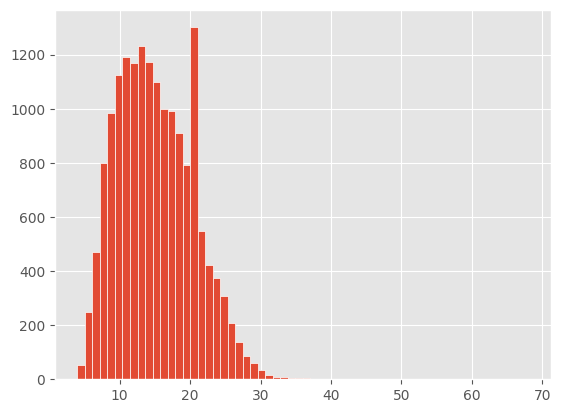

In [9]:
plt.hist([len(s) for s in sentences], bins=60, edgecolor = "white")
plt.show()

In [10]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [11]:
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences, to_categorical

In [12]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [13]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [14]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [15]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [16]:
y.shape

(16767, 50)

In [17]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [18]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [41]:
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Dropout

In [20]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)  # 50-dim embedding
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  # biderctional biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [21]:
model = Model(input, out)

In [22]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1707050   
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 68)           13668     
 ibuted)                                                         
                                                                 
Total params: 1,841,518
Trainable params: 1,841,518
Non-train

In [25]:
history = model.fit(X_tr, np.array(y_tr), batch_size=128, epochs=5, validation_split=0.1, verbose=1)

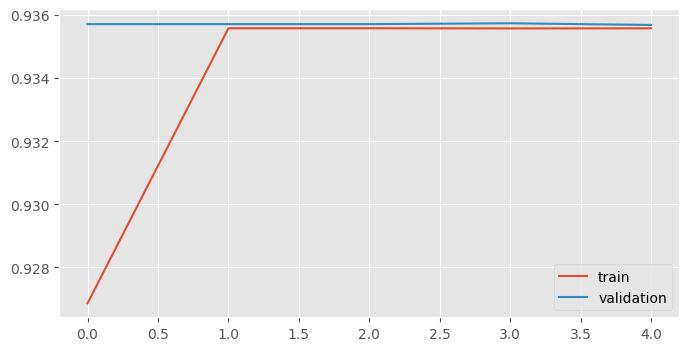

In [ ]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(8,4))
plt.plot(hist["accuracy"], label="train")
plt.plot(hist["val_accuracy"], label="validation")
plt.legend()
plt.show()

In [39]:
i = 100
p = model.predict(np.array([X_te[i]]))
# p.shape
p = np.argmax(p, axis=-1); p[0]
# print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
# for w, pred in zip(X_te[i], p[0]):
#     print("{:15} {:5}: ".format(words[w], tags[pred]))

1/1 [==============================] - 0s 17ms/step


array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36],
      dtype=int64)